In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
import multiprocessing

from joblib import Parallel, delayed
from tqdm import tqdm

# Sklearn 用於階層式聚類與相關距離計算
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
print(f"CPU核心數量: {multiprocessing.cpu_count()}")

CPU核心數量: 64


In [2]:
# 請根據你的環境設定資料夾路徑
DATA_DIR = "D:\\Data\\Kline\\UsdFutures"  # 調整為你的資料夾位置

# 假設每個 CSV 名稱格式如 BTCUSDT.csv, ETHUSDT.csv, ...
file_list = glob.glob(os.path.join(DATA_DIR, '*.csv'))
print(f"找到 {len(file_list)} 個 CSV 檔案")

# 移動平均視窗設定（例如5分鐘移動平均降噪）
WINDOW = 15  

# 若資料量超大，可設定 chunk size，例如：1_000_000；否則設定 None 一次讀取
CHUNK_SIZE = None  

# CSV欄位名稱設定 (請依實際檔案內容調整)
TIME_COL = 'OpenTime'
OPEN_COL = 'OpenPrice'
HIGH_COL = 'HighPrice'
LOW_COL = 'LowPrice'
CLOSE_COL = 'ClosePrice'
VOLUME_COL = 'QuoteVolume'

# 計算相關時使用的價格欄位 (這裡以 close 為例)
PRICE_COL = CLOSE_COL


找到 372 個 CSV 檔案


In [3]:
def process_average_volume(file_path,
                           time_col=TIME_COL,
                            volume_col=VOLUME_COL):
    """
    讀取 CSV，將 timestamp 欄位設為索引，
    依 1 小時重採樣 (將 Volume 加總)，並計算平均成交量。
    """
    try:
        # 根據實際 CSV 格式調整欄位名稱，此處假設時間欄位為 "timestamp"
        df = pd.read_csv(file_path)
        df[time_col] = pd.to_datetime(df[time_col], unit='ms', utc=True, errors='coerce')
        df.set_index(time_col, inplace=True)
        
        # 重採樣：1 小時內將 Volume 加總
        hourly_volume = df[volume_col].resample("1h").sum()
        
        # 計算所有小時成交量的平均值
        avg_volume = hourly_volume.mean()
        del df
        gc.collect()
        return file_path, avg_volume
    except Exception as e:
        print(f"處理 {file_path} 時發生錯誤: {e}")
        return file_path, None

In [4]:
def process_single_csv(file_path,
                       time_col=TIME_COL,
                       price_col=PRICE_COL,
                       window=WINDOW,
                       chunksize=CHUNK_SIZE):
    """
    讀取單個 CSV，計算對數收益並做移動平均降噪。
    返回 DataFrame: [timestamp, symbol, smoothed_log_return]
    """
    # 根據檔名推測交易對 symbol，例如 'BTCUSDT.csv' -> 'BTCUSDT'
    symbol = os.path.splitext(os.path.basename(file_path))[0]

    df_list = []

    if chunksize is None:
        # 一次性讀取
        df_raw = pd.read_csv(file_path)
        # 取需要的欄位
        df_raw = df_raw[[time_col, price_col]].dropna()
        # 排序保證時間先後
        df_raw.sort_values(by=time_col, inplace=True)
        # 計算對數收益
        df_raw['log_price'] = np.log(df_raw[price_col])
        df_raw['log_return'] = df_raw['log_price'].diff()
        # 移動平均降噪
        df_raw['smoothed_log_return'] = df_raw['log_return'].rolling(window, min_periods=1).mean()
        # 加上 symbol 欄
        df_raw['symbol'] = symbol

        # 移除第一筆 (diff會產生 NaN) 與其他缺失值
        df_raw.dropna(subset=['smoothed_log_return'], inplace=True)

        result = df_raw[[time_col, 'symbol', 'smoothed_log_return']]
        df_list.append(result)

        # 釋放暫存記憶體
        del df_raw
        gc.collect()
    else:
        # 若資料量太大，分 chunk 讀取
        reader = pd.read_csv(file_path, chunksize=chunksize)
        prev_log_price = None

        for chunk in reader:
            chunk = chunk[[time_col, price_col]].dropna()
            chunk.sort_values(by=time_col, inplace=True)
            chunk['log_price'] = np.log(chunk[price_col])

            # 若有前一個 chunk 的最後一筆 log_price，計算第一筆的 diff
            if prev_log_price is not None:
                chunk.loc[chunk.index[0], 'log_return'] = chunk.loc[chunk.index[0], 'log_price'] - prev_log_price
            chunk['log_return'] = chunk['log_price'].diff()

            # 移動平均降噪 (此處僅在每個 chunk 內做 rolling)
            chunk['smoothed_log_return'] = chunk['log_return'].rolling(window, min_periods=1).mean()

            # 記錄最後一筆 log_price，供下一個 chunk 使用
            prev_log_price = chunk.loc[chunk.index[-1], 'log_price']

            chunk['symbol'] = symbol
            chunk.dropna(subset=['smoothed_log_return'], inplace=True)
            df_list.append(chunk[[time_col, 'symbol', 'smoothed_log_return']])
            
            del chunk
            gc.collect()

    if len(df_list) > 0:
        df_final = pd.concat(df_list, ignore_index=True)
    else:
        df_final = pd.DataFrame(columns=[time_col, 'symbol', 'smoothed_log_return'])
    
    return df_final

In [5]:
# 設定並行執行核心數量 (建議保留1個核心給系統)
n_jobs = min(6, max(multiprocessing.cpu_count() - 1, 1))

results = Parallel(n_jobs=n_jobs)(delayed(process_average_volume)(fp) for fp in file_list)
results = [(fp, avg) for fp, avg in results if avg is not None]
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
top_100 = results_sorted[:100]
top_100_files = [fp for fp, avg in top_100]

del results
del results_sorted
del top_100
gc.collect()
print('Done')

processed_list = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(process_single_csv)(file) for file in top_100_files
)

# 拼接所有市場資料
df_all = pd.concat(processed_list, ignore_index=True)

# 釋放暫存

del top_100_files
del processed_list
gc.collect()

print("處理完成，df_all 行數:", len(df_all))
df_all.head()

Done


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.11463475227355957s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Batch computation too slow (3.448011636734009s.) Setting batch_size=1.
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:   13.0s
[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed:   15.6s
[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done  72 tasks      | elapsed:   22.7s
[Parallel(n_jobs=6)]: Done  85 tasks      | elapsed:   28.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   35.9s finished


處理完成，df_all 行數: 71722810


,OpenTime,symbol,smoothed_log_return
0,1645747260000,BTCUSDT,-0.001425
1,1645747320000,BTCUSDT,-0.000984
2,1645747380000,BTCUSDT,-0.000644
3,1645747440000,BTCUSDT,-0.000385
4,1645747500000,BTCUSDT,-0.000329


In [6]:
# 將 timestamp 欄位轉成 datetime，根據你的時間格式調整 unit (例如: 'ms' 或 's')
df_all[TIME_COL] = pd.to_datetime(df_all[TIME_COL], unit='ms', utc=True, errors='coerce')
df_all.dropna(subset=[TIME_COL], inplace=True)

# 轉寬格式：index 為 timestamp，columns 為 symbol，值為 smoothed_log_return
df_pivot = df_all.pivot(index=TIME_COL, columns='symbol', values='smoothed_log_return')

# 依據時間重新索引，確保每分鐘都有資料
date_range = pd.date_range(
    start=df_pivot.index.min().floor('min'),
    end=df_pivot.index.max().ceil('min'),
    freq='1T'  # 每1分鐘
)
df_pivot = df_pivot.reindex(date_range)

# 缺失值填 0 或其他適當值
df_pivot = df_pivot.fillna(0)

print("寬格式資料形狀:", df_pivot.shape)
df_pivot.head()


C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_8744\85144078.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(


寬格式資料形狀: (1578240, 100)


symbol,1MBABYDOGEUSDT,AAVEUSDT,ACTUSDT,ADAUSDT,AI16ZUSDT,AIXBTUSDT,APEUSDT,APTUSDT,ARBUSDT,ARCUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BANUSDT,BCHUSDT,BERAUSDT,BNBUSDT,BOMEUSDT,BTCUSDC,BTCUSDT,CFXUSDT,COWUSDT,CRVUSDT,DOGEUSDT,DOGSUSDT,DOTUSDT,DYDXUSDT,EIGENUSDT,ENAUSDT,EOSUSDT,ETCUSDT,ETHFIUSDT,ETHUSDC,ETHUSDT,FARTCOINUSDT,FETUSDT,FILUSDT,GALAUSDT,GMTUSDT,GOATUSDT,GRIFFAINUSDT,HEIUSDT,HIVEUSDT,INJUSDT,IOUSDT,IPUSDT,JTOUSDT,JUPUSDT,KAITOUSDT,LAYERUSDT,LINKUSDT,LTCUSDT,MASKUSDT,MELANIAUSDT,MEUSDT,MEWUSDT,MOCAUSDT,MOODENGUSDT,MOVEUSDT,NEARUSDT,NEIROETHUSDT,NEIROUSDT,NOTUSDT,ONDOUSDT,OPUSDT,ORDIUSDT,PENGUUSDT,PEOPLEUSDT,PNUTUSDT,POPCATUSDT,RAREUSDT,SAGAUSDT,SANDUSDT,SEIUSDT,SHELLUSDT,SOLUSDC,SOLUSDT,STXUSDT,SUIUSDT,SWARMSUSDT,TAOUSDT,THEUSDT,TIAUSDT,TONUSDT,TRBUSDT,TROYUSDT,TRUMPUSDT,TRXUSDT,TSTUSDT,TURBOUSDT,USUALUSDT,UXLINKUSDT,VANAUSDT,VINEUSDT,VIRTUALUSDT,VVVUSDT,WIFUSDT,WLDUSDT,XRPUSDT,ZROUSDT
2022-02-25 00:01:00+00:00,0.0,-0.006152,0.0,-0.005165,0.0,0.0,0.0,0.0,0.0,0.0,-0.004955,-0.005515,-0.009055,0.0,-0.005871,0.0,-0.002966,0.0,0.0,-0.001425,0.0,0.0,-0.005805,-0.006152,0.0,-0.004209,-0.005976,0.0,0.0,-0.004351,-0.006503,0.0,0.0,-0.002628,0.0,0.0,-0.004076,-0.008226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005211,-0.003460,-0.004751,0.0,0.0,0.0,0.0,0.0,0.0,-0.005426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.010457,0.0,0.0,0.0,0.0,-0.006464,0.0,0.0,0.0,-0.004028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005139,0.0,0.0,-0.002955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006041,0.0
2022-02-25 00:02:00+00:00,0.0,-0.002596,0.0,-0.003112,0.0,0.0,0.0,0.0,0.0,0.0,-0.003185,-0.003021,-0.003908,0.0,-0.003689,0.0,-0.001525,0.0,0.0,-0.000984,0.0,0.0,-0.002902,-0.002346,0.0,-0.001981,-0.002289,0.0,0.0,-0.002418,-0.002588,0.0,0.0,-0.001395,0.0,0.0,-0.001902,-0.003385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002038,-0.001105,-0.002375,0.0,0.0,0.0,0.0,0.0,0.0,-0.003305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004083,0.0,0.0,0.0,0.0,-0.001290,0.0,0.0,0.0,-0.002912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002054,0.0,0.0,-0.001478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003453,0.0
2022-02-25 00:03:00+00:00,0.0,-0.001891,0.0,-0.002075,0.0,0.0,0.0,0.0,0.0,0.0,-0.002366,-0.002497,-0.003777,0.0,-0.001968,0.0,-0.001063,0.0,0.0,-0.000644,0.0,0.0,-0.002084,-0.001564,0.0,-0.001052,-0.001061,0.0,0.0,-0.001450,-0.001448,0.0,0.0,-0.000975,0.0,0.0,-0.000959,-0.002639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000905,-0.001250,-0.001504,0.0,0.0,0.0,0.0,0.0,0.0,-0.002440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001453,0.0,0.0,0.0,0.0,-0.001015,0.0,0.0,0.0,-0.002541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001198,0.0,0.0,-0.001040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000909,0.0
2022-02-25 00:04:00+00:00,0.0,-0.001338,0.0,-0.001527,0.0,0.0,0.0,0.0,0.0,0.0,-0.001461,-0.001148,-0.002626,0.0,-0.001033,0.0,-0.000776,0.0,0.0,-0.000385,0.0,0.0,-0.001116,-0.001213,0.0,-0.000464,-0.000348,0.0,0.0,-0.000483,-0.001133,0.0,0.0,-0.000441,0.0,0.0,-0.000543,-0.002090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000547,-0.000985,-0.000771,0.0,0.0,0.0,0.0,0.0,0.0,-0.001860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001042,0.0,0.0,0.0,0.0,-0.000960,0.0,0.0,0.0,-0.001568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000256,0.0,0.0,-0.000492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000970,0.0
2022-02-25 00:05:00+00:00,0.0,-0.000862,0.0,-0.000962,0.0,0.0,0.0,0.0,0.0,0.0,-0.000999,-0.000551,-0.001687,0.0,-0.000466,0.0,-0.000521,0.0,0.0,-0.000329,0.0,0.0,0.000000,-0.000647,0.0,-0.000247,0.000238,0.0,0.0,-0.000290,-0.000423,0.0,0.0,-0.000331,0.0,0.0,-0.000282,-0.001239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000226,-0.000557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.001038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001207,0.0,0.0,0.0,0.0,0.000363,0.0,0.0,0.0,-0.001030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000102,0.0,0.0,-0.000492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000776,0.0


In [7]:
# 使用皮爾遜相關係數計算市場間相似度 (columns 為 symbol)
cor_matrix = df_pivot.corr(method='pearson')
print("相關矩陣大小:", cor_matrix.shape)
cor_matrix.head()


相關矩陣大小: (100, 100)


symbol,1MBABYDOGEUSDT,AAVEUSDT,ACTUSDT,ADAUSDT,AI16ZUSDT,AIXBTUSDT,APEUSDT,APTUSDT,ARBUSDT,ARCUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BANUSDT,BCHUSDT,BERAUSDT,BNBUSDT,BOMEUSDT,BTCUSDC,BTCUSDT,CFXUSDT,COWUSDT,CRVUSDT,DOGEUSDT,DOGSUSDT,DOTUSDT,DYDXUSDT,EIGENUSDT,ENAUSDT,EOSUSDT,ETCUSDT,ETHFIUSDT,ETHUSDC,ETHUSDT,FARTCOINUSDT,FETUSDT,FILUSDT,GALAUSDT,GMTUSDT,GOATUSDT,GRIFFAINUSDT,HEIUSDT,HIVEUSDT,INJUSDT,IOUSDT,IPUSDT,JTOUSDT,JUPUSDT,KAITOUSDT,LAYERUSDT,LINKUSDT,LTCUSDT,MASKUSDT,MELANIAUSDT,MEUSDT,MEWUSDT,MOCAUSDT,MOODENGUSDT,MOVEUSDT,NEARUSDT,NEIROETHUSDT,NEIROUSDT,NOTUSDT,ONDOUSDT,OPUSDT,ORDIUSDT,PENGUUSDT,PEOPLEUSDT,PNUTUSDT,POPCATUSDT,RAREUSDT,SAGAUSDT,SANDUSDT,SEIUSDT,SHELLUSDT,SOLUSDC,SOLUSDT,STXUSDT,SUIUSDT,SWARMSUSDT,TAOUSDT,THEUSDT,TIAUSDT,TONUSDT,TRBUSDT,TROYUSDT,TRUMPUSDT,TRXUSDT,TSTUSDT,TURBOUSDT,USUALUSDT,UXLINKUSDT,VANAUSDT,VINEUSDT,VIRTUALUSDT,VVVUSDT,WIFUSDT,WLDUSDT,XRPUSDT,ZROUSDT
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1MBABYDOGEUSDT,1.000000,0.220007,0.317915,0.259244,0.267523,0.244641,0.232355,0.241694,0.303184,0.189280,0.239928,0.223539,0.213636,0.221006,0.214852,0.067849,0.207534,0.378593,0.289673,0.176728,0.255560,0.363327,0.224057,0.254255,0.557600,0.255873,0.223211,0.480988,0.332770,0.239041,0.216133,0.385935,0.367979,0.225095,0.238514,0.247183,0.223605,0.241210,0.194089,0.432818,0.243527,0.048025,0.201190,0.237692,0.407079,0.026581,0.261813,0.321420,0.009380,0.047231,0.246954,0.233349,0.159284,0.148769,0.295705,0.428991,0.217089,0.388816,0.232559,0.223321,0.462083,0.609868,0.403704,0.297948,0.217702,0.301132,0.294792,0.212043,0.333059,0.484003,0.418706,0.380303,0.234589,0.286852,0.031190,0.311021,0.166051,0.254840,0.273157,0.217809,0.356027,0.323809,0.288016,0.307937,0.181562,0.277496,0.140185,0.169701,0.065394,0.492835,0.250367,0.308313,0.256488,0.119784,0.319038,0.144760,0.303183,0.294710,0.225655,0.426812
AAVEUSDT,0.220007,1.000000,0.152312,0.674108,0.142541,0.129563,0.612326,0.481587,0.483515,0.100049,0.680980,0.696102,0.643977,0.115457,0.616128,0.035315,0.655903,0.323222,0.385067,0.661272,0.432504,0.196368,0.635024,0.613271,0.264529,0.703989,0.646685,0.260319,0.309261,0.644542,0.678114,0.369978,0.454232,0.731719,0.134540,0.442395,0.643215,0.648455,0.565349,0.203815,0.130989,0.021937,0.107029,0.477862,0.281396,0.016031,0.338101,0.366274,0.006133,0.023480,0.710539,0.644240,0.587704,0.082829,0.153547,0.275033,0.111107,0.179295,0.126388,0.662335,0.200623,0.207351,0.275359,0.331325,0.573474,0.369200,0.155872,0.523248,0.158010,0.237438,0.229116,0.311794,0.681439,0.385221,0.016673,0.397533,0.636554,0.427919,0.417833,0.108809,0.329438,0.164640,0.363418,0.325480,0.487999,0.141848,0.080341,0.482578,0.029275,0.270145,0.134956,0.144849,0.131821,0.061426,0.181802,0.083224,0.319795,0.385427,0.565834,0.296101
ACTUSDT,0.317915,0.152312,1.000000,0.173888,0.246594,0.229890,0.156083,0.164603,0.206716,0.170667,0.166930,0.152879,0.147732,0.235487,0.142850,0.046938,0.127618,0.250195,0.188041,0.114758,0.172674,0.336646,0.165538,0.166840,0.359045,0.180394,0.151638,0.343218,0.229867,0.173177,0.148405,0.252912,0.239189,0.146303,0.222698,0.166016,0.150903,0.165732,0.132360,0.414157,0.225389,0.030714,0.159829,0.159906,0.276401,0.022411,0.177717,0.224668,0.012515,0.030075,0.172077,0.168484,0.118955,0.124895,0.265314,0.259172,0.190072,0.339864,0.212001,0.148511,0.299049,0.335754,0.259542,0.197969,0.141356,0.198940,0.277472,0.135071,0.546831,0.359463,0.289309,0.253897,0.166959,0.194741,0.020608,0.217707,0.116239,0.171153,0.181900,0.221341,0.245807,0.302003,0.195106,0.201856,0.120048,0.249714,0.113483,0.138797,0.043051,0.272778,0.225040,0.207687,0.237631,0.091107,0.292228,0.099695,0.204770,0.200333,0.163006,0.290486
ADAUSDT,0.259244,0.674108,0.173888,1.000000,0.166440,0.148294,0.635861,0.529321,0.525073,0.113249,0.723030,0.733965,0.670313,0.140683,0.657082,0.037096,0.686235,0.366725,0.446571,0.688943,0.486033,0.226244,0.630835,0.662281,0.311313,0.777393,0.652647,0.279292,0.3

In [8]:
# 轉換相關係數為距離矩陣 (distance = 1 - correlation)
dist_matrix = 1 - cor_matrix

# 設定要分的群數 (可根據分析結果調整)
n_clusters = 5

# 使用 AgglomerativeClustering，affinity='precomputed' 需傳入距離矩陣
model = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='average'
).fit(dist_matrix)

labels = model.labels_
symbols = cor_matrix.index.tolist()

# 建立 DataFrame 檢視每個 symbol 的 cluster 分群結果
df_clusters = pd.DataFrame({'symbol': symbols, 'cluster': labels})
df_clusters.sort_values('cluster', inplace=True)
df_clusters.head(30)


,symbol,cluster
49,LAYERUSDT,0
41,HEIUSDT,0
88,TSTUSDT,0
0,1MBABYDOGEUSDT,1
4,AI16ZUSDT,1
5,AIXBTUSDT,1
2,ACTUSDT,1
1,AAVEUSDT,1
8,ARBUSDT,1
9,ARCUSDT,1


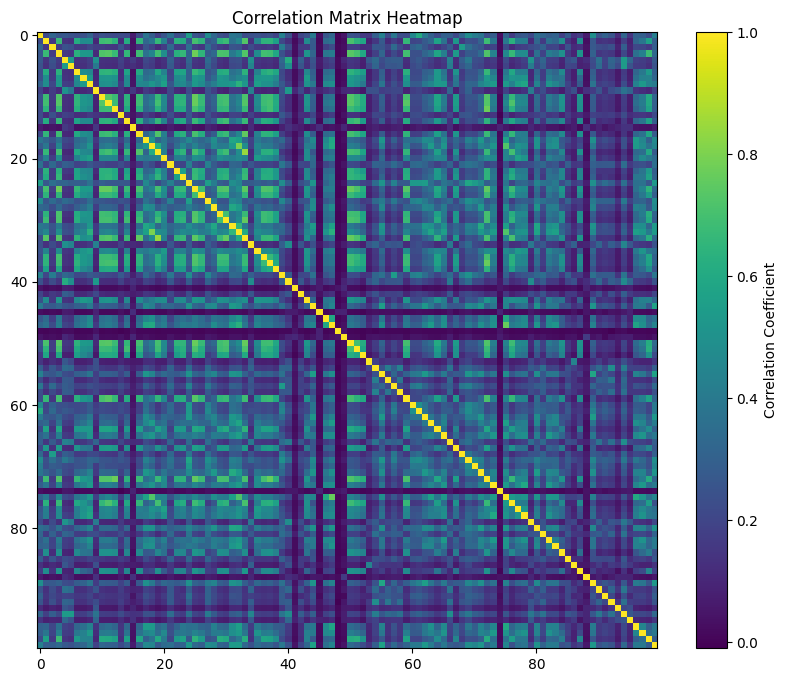

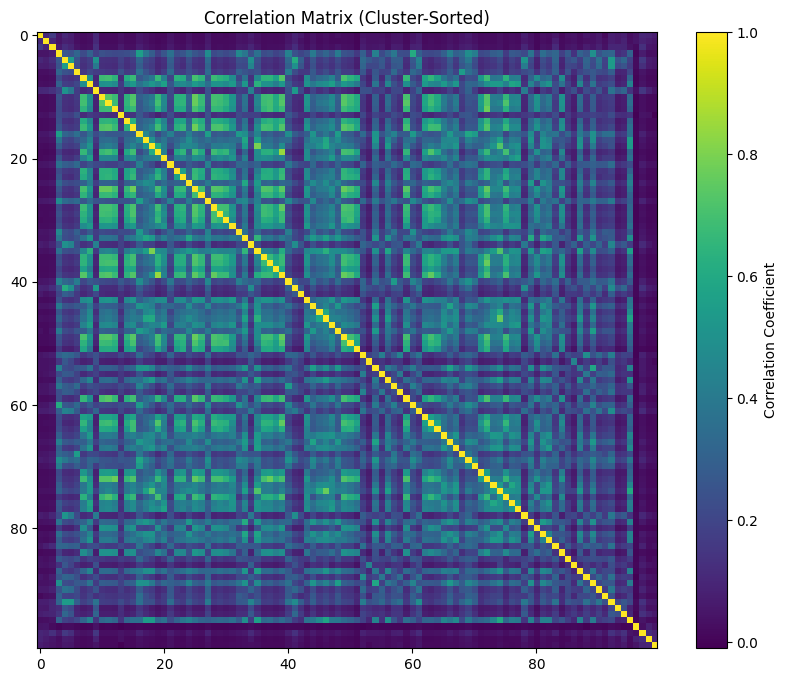

In [9]:
# 畫出原始相關係數熱力圖
plt.figure(figsize=(10, 8))
plt.imshow(cor_matrix, aspect='auto', interpolation='nearest')
plt.title("Correlation Matrix Heatmap")
plt.colorbar(label='Correlation Coefficient')
plt.show()

# 根據聚類結果重新排序市場
sorted_symbols = df_clusters['symbol'].values.tolist()
sorted_index = [symbols.index(sym) for sym in sorted_symbols]
sorted_cor = cor_matrix.values[sorted_index][:, sorted_index]

plt.figure(figsize=(10, 8))
plt.imshow(sorted_cor, aspect='auto', interpolation='nearest')
plt.title("Correlation Matrix (Cluster-Sorted)")
plt.colorbar(label='Correlation Coefficient')
plt.show()


In [10]:
import itertools

# 從相關矩陣取得所有市場名稱 (假設 cor_matrix 是先前計算好的 DataFrame)
symbols = cor_matrix.columns.tolist()

# 產生所有獨特的市場配對 (不含自配對)
pairs = []
for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        m1 = symbols[i]
        m2 = symbols[j]
        corr_value = cor_matrix.loc[m1, m2]
        pairs.append((m1, m2, corr_value))

# 依照相關係數由大到小排序
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

# 按照不重複市場的原則，依序挑選 5 組
selected_pairs = []
used_markets = set()

for pair in pairs_sorted:
    m1, m2, corr_value = pair
    if m1 not in used_markets and m2 not in used_markets:
        selected_pairs.append(pair)
        used_markets.add(m1)
        used_markets.add(m2)
    if len(selected_pairs) == 5:
        break

# 列印出結果
print("選出的 5 組最高度相關的市場及其相關係數:")
for m1, m2, corr_value in selected_pairs:
    print(f"{m1} <--> {m2} : {corr_value:.4f}")


選出的 5 組最高度相關的市場及其相關係數:
BTCUSDT <--> ETHUSDT : 0.8448
BTCUSDC <--> ETHUSDC : 0.7976
ADAUSDT <--> DOTUSDT : 0.7774
AXSUSDT <--> SANDUSDT : 0.7725
JUPUSDT <--> SOLUSDC : 0.7654
